In [2]:
import numpy as np
import os

In [3]:
def preparedata_time_window(input_data,window):
    out_data = []
    # rearrange the input in form of output based on 3 observations in past
    for i in range(len(input_data)):
        if (i+window+1) <= len(input_data):
            out_data.append((input_data[i:i+window],input_data[i+window:i+(window+1)]))
            
    return out_data

In [4]:
import pandas as pd

In [5]:
import torch
from torch import nn     
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

In [6]:
# df = pd.read_csv('https://raw.githubusercontent.com/riteshsv/simplelstm/main/tsdata.csv')
# df.columns=['sales']
# df.head()

In [7]:
df = pd.read_csv('/content/timeseries/ULTRACEMCO.NS.csv')
# df.columns=['sales']
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-16,8120.0,8139.000000,7856.299805,7882.399902,7837.409180,277983
1,2021-11-17,7845.0,7948.950195,7801.000000,7857.700195,7812.850586,183623
2,2021-11-18,7899.0,7930.000000,7715.049805,7767.700195,7723.364258,196805
3,2021-11-22,7799.0,7808.600098,7550.600098,7653.799805,7610.113770,383629
4,2021-11-23,7620.0,7714.700195,7540.700195,7657.950195,7614.240723,475377


In [8]:
df['Date'].min()

'2021-11-16'

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
data = df['Close'].values.astype(float)

In [11]:
data.shape

(249,)

In [12]:
# X = np.array(X)
# y = np.array(y)

In [13]:
# scaler = MinMaxScaler(feature_range=(-1,1))
# scaled_input = scaler.fit_transform( np.array(input_data).reshape(-1,1))

In [14]:
# train_data = preparedata_time_window(torch.tensor(scaled_input,dtype=torch.float32).view(-1),3)

In [109]:
class LSTMSimple(nn.Module):
    def __init__(self, input_dim,hidden_dim,out_size,num_layers=1,batch_size=1):
        super(LSTMSimple,self).__init__()
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim,out_size)
        self.hidden = (torch.zeros(1*num_layers,batch_size,hidden_dim),torch.zeros(1*num_layers,batch_size,hidden_dim))
    def forward(self,x):
      self.hidden = (torch.zeros(1,1,50,device=device),torch.zeros(1,1,50,device=device))
      out,self.hidden = self.lstm(x.view(-1,self.batch_size,len(x)),self.hidden)
      preds = self.out(out[-1])
      return preds[0]

In [117]:
class Trainer():
  def __init__(self,model,train_data,loss_fn,optimizer,val_data=None,epochs=1):
    self.model = model
    self.epochs = epochs
    self.train_data = train_data
    self.val_data = val_data
    self.loss_fn = loss_fn
    self.optimizer = optimizer
  def train(self):
    for epoch in range(self.epochs):
      self.model.train()
      train_loss = 0.0  
      for x,t in self.train_data:
        self.model.zero_grad()
        preds = model(x)
        loss = self.loss_fn(preds,t)
        loss.backward()
        self.optimizer.step()
        train_loss += loss.item()
      train_loss = train_loss/len(self.train_data)
      if self.val_data != None:
        val_loss = self.__validation()
      if epoch%10 == 0:
        print(f"Epoch: {epoch} loss: {train_loss} validation loss: {val_loss}")
  def __validation(self):
    self.model.eval()  
    val_loss = 0.0
    with torch.no_grad():
      for x,t in self.val_data:
        preds = self.model(x)
        loss = self.loss_fn(preds,t)
        val_loss += loss.item()
    return val_loss/len(self.val_data)

In [118]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [119]:
model = LSTMSimple(1,50,1)
model.to(device)

LSTMSimple(
  (lstm): LSTM(1, 50)
  (out): Linear(in_features=50, out_features=1, bias=True)
)

In [120]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=0.001)


In [20]:
# def train(train_data):
#     for epoch in range(100):
#         for x,t in train_data:
#             model.zero_grad()
#             model.hidden = (torch.zeros(1,1,50,device=device),torch.zeros(1,1,50,device=device))

#             preds = model(x)
#             loss = loss_fn(preds,t)
#             loss.backward()
#             optimizer.step()
#         if epoch%25 == 0:
#             print(f"epoch: {epoch} loss:{loss.item()}")
        

        

In [21]:
class StandardizeInput():
  def __init__(self):
    self.scaler = MinMaxScaler(feature_range=(-1,1)) 
  def __call__(self,data):
    return self.scaler.fit_transform(data)

# scaler2 = MinMaxScaler(feature_range=(-1,1))
# scaled_input2 = scaler2.fit_transform(data.reshape(-1,1))


Perform a train test split

In [22]:
# test_size = 50
# train_data = preparedata_time_window(torch.tensor(scaled_input2[:-test_size],dtype=torch.float32,device=device).view(-1),14)
# test_data = preparedata_time_window(torch.tensor(scaled_input2[-test_size:],dtype=torch.float32,device=device).view(-1),14)

In [23]:
class UnivariateTsDataset(Dataset):
    """Univariate time serices dataset."""

    def __init__(self, csv_file, target:str=None, transform=None, window=1,features:list=None,n_features=1,scaler=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            window (integer): Number of time steps in the past
            features (list) : list of features to be used, default is all features
            n_features (integer) : number of features to be used. default is 1, min number of features required
        """
        self.transform = transform
        self.target = target
        self.window = window
        self.features = features
        self.scaler=scaler
        if len(self.features) > 0:
          self.n_features = len(self.features)
        else:
          self.n_features = n_features
        self.data = self.preprocess(pd.read_csv(csv_file))
    
    def preprocess(self,input_df):
      if self.features != None:
        input_data = input_df[self.features]
      else:
        input_data = input_df
      # scaling
      if self.scaler != None:
        input_data = self.scaler(input_data)
      # convert to tensors
      input_data_tensor = torch.tensor(input_data,dtype=torch.float32,device=device).view(-1)
      out_data = []
      # rearrange the input in form of output based on 3 observations in past
      for i in range(len(input_data_tensor)):
        if (i+self.window+1) <= len(input_data_tensor):
          out_data.append((input_data_tensor[i:i+self.window],input_data_tensor[i+self.window:i+(self.window+1)]))
            
      return out_data
    
    def train_val_test_split(self,train_size=0.8,test_size=.20,val_size=0.0):
      train_len = int(train_size*len(self.data))
      train_set = torch.utils.data.Subset(self,np.arange(train_len))
      val_len = int(len(self.data)*val_size)
      if val_size > 0:
        val_set = torch.utils.data.Subset(self,np.arange(train_len,(train_len+val_len)))
      test_set = torch.utils.data.Subset(self,np.arange((train_len+val_len),len(self.data)))
      if val_size > 0:
        return train_set,val_set,test_set
      return train_set,test_set

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = self.data[idx]

        return sample

In [24]:
dataset = UnivariateTsDataset('/content/timeseries/ULTRACEMCO.NS.csv',window=14,features=['Close'],n_features=1,scaler=StandardizeInput())

In [25]:
train_set,val_set,test_set = dataset.train_val_test_split(0.60,0.20,0.20)


In [26]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=False)


In [56]:
for x,y in train_loader:
  z = x.view(-1,1,len(x))
  print(z.shape)
  break

torch.Size([14, 1, 1])


In [121]:
trainer = Trainer(model,train_loader,loss_fn,optimizer,val_loader,100)

In [122]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 loss: 0.2826170977423833 validation loss: 0.06789766592282831
Epoch: 10 loss: 0.17757709629016713 validation loss: 0.05628883639265234
Epoch: 20 loss: 0.08750792919397313 validation loss: 0.02197260465878968
Epoch: 30 loss: 0.029442126750049966 validation loss: 0.008921600431349628
Epoch: 40 loss: 0.01664440648287136 validation loss: 0.012380167472409742
Epoch: 50 loss: 0.015350573003264322 validation loss: 0.014570247888973717
Epoch: 60 loss: 0.015121628597799466 validation loss: 0.014995485281227705
Epoch: 70 loss: 0.014977173369412889 validation loss: 0.014927047234047502
Epoch: 80 loss: 0.01484652991502252 validation loss: 0.014751861916111953
Epoch: 90 loss: 0.014722331570660475 validation loss: 0.014559208540680008


In [130]:
def test(test_data):
   model.eval()  
   test_loss = 0.0
   preds = []
   with torch.no_grad():
     for x,t in test_data:
       pred = model(x)
       loss = loss_fn(pred,t)
       test_loss += loss.item()
       preds.append(pred)
     print(test_loss/len(test_data))
   return preds

In [131]:
p = test(test_loader)

0.014367815271829714


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
p

In [134]:
p_a = []
for x in p:
  p_a.append(dataset.scaler.scaler.inverse_transform(np.array(x.view(-1).cpu()).reshape(-1,1)))

In [ ]:
p_a

In [192]:
def predict(n_preds):
  out = []
  with torch.no_grad():
    input_ten = dataset[-1][0]
    for p in range(n_preds):
      input_ten = input_ten[-14:].view(-1,14)
      model.hidden = (torch.zeros(1,1,50,device=device),torch.zeros(1,1,50,device=device))
      preds = model(input_ten)
      input_ten = torch.cat((input_ten.view(-1),preds),0)
      actual_pred = dataset.scaler.scaler.inverse_transform(np.array(preds.view(-1).cpu()).reshape(-1,1))
      out.append(actual_pred)
      print(actual_pred)
  return out

In [193]:
actual = predict(10)

[[6849.079]]
[[6839.248]]
[[6828.948]]
[[6818.4087]]
[[6807.34]]
[[6795.9424]]
[[6784.39]]
[[6772.6836]]
[[6760.5444]]
[[6748.071]]


In [202]:
ap = [x.reshape(1)[0] for x in actual]
ap


[6849.079,
 6839.248,
 6828.948,
 6818.4087,
 6807.34,
 6795.9424,
 6784.39,
 6772.6836,
 6760.5444,
 6748.071]

In [203]:
df = pd.read_csv('/content/timeseries/ULTRACEMCO.NS.csv')

In [230]:
df2 = pd.DataFrame(pd.date_range('2022-11-17',periods=10).date)
df2.columns = ['Date']
df2['ap'] = ap

In [231]:
df3 = pd.concat([df,df2],axis=0)

In [232]:
df4 = df3[-30:]
df4.shape

(30, 8)

In [240]:
df4[-10:]

,Date,Open,High,Low,Close,Adj Close,Volume,ap
0,2022-11-17,NaN,NaN,NaN,NaN,NaN,NaN,6849.079102
1,2022-11-18,NaN,NaN,NaN,NaN,NaN,NaN,6839.248047
2,2022-11-19,NaN,NaN,NaN,NaN,NaN,NaN,6828.948242
3,2022-11-20,NaN,NaN,NaN,NaN,NaN,NaN,6818.408691
4,2022-11-21,NaN,NaN,NaN,NaN,NaN,NaN,6807.339844
5,2022-11-22,NaN,NaN,NaN,NaN,NaN,NaN,6795.942383
6,2022-11-23,NaN,NaN,NaN,NaN,NaN,NaN,6784.390137
7,2022-11-24,NaN,NaN,NaN,NaN,NaN,NaN,6772.683594
8,2022-11-25,NaN,NaN,NaN,NaN,NaN,NaN,6760.544434
9,2022-11-26,NaN,NaN,NaN,NaN,NaN,NaN,6748.070801


In [233]:
from matplotlib import pyplot as plt

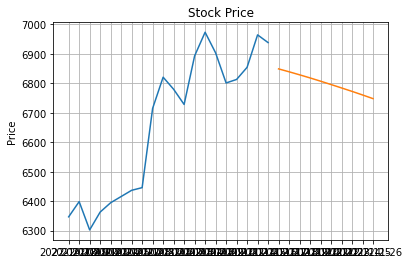

In [241]:
plt.title('Stock Price')
plt.ylabel('Price')
plt.grid(True)

plt.plot(df4['Date'].astype(str),df4['Close'])
plt.plot(df4['Date'].astype(str),df4['ap'])
plt.show()

In [1]:
!git clone https://github.com/riteshsv/timeseries.git

Cloning into 'timeseries'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


0

# New Section